In this lab we consider the same learning setting as in Lab 1, but now we will apply different decentralized algorithms from Lecture 4. This allows us to illustrate several performance trade-offs, that will be analyzed in detail in Lecture 5. These are reproduced from slides 36 of Lecture 5 onwards, although this lab can be completed already following Lecture 4 if desired. This will provide a preview of the material covered in Lecture 5. As in Lab 2, we begin by importing some standard libraries. We also set the random seed for consistency of the results, although this can be removed freely.

In [79]:
# Numpy and Matplotlib for array manipulation and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Pytorch for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import copy

seed_nr = 0
np.random.seed(seed_nr)
torch.manual_seed(seed_nr)
torch.backends.cudnn.enabled = False

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


We set the parameters for the distributions of features, noise and model, as well as the iteration count, number of experiments to average over, dimension of the linear model and number of agents. The parameters in this cell are the ones we will be primarly varying to obtain numerical results in different settings.

We also set the base model to the vector of all ones.

We also generate a set of weights $w_k^o$, along with the corresponding globally optimal model $w^o$. It can be verified that, since the regressor covariances $R_h$ are common across agents, it holds that $w^o = \frac{1}{K} \sum_{k=1}^K w_k^o$.

Finally, we set the step-size.

You are encouraged to vary these parameters and see if the numerical results conform with the analytical results in the lectures.

In [80]:
nr_agents = 8
local_batch_size = 8
centralized_batch_size = local_batch_size * nr_agents
step_size = 0.01
momentum = 0

transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

centralized_train_set = datasets.MNIST('./data/', train=True, download=True, transform=transform)
centralized_test_set = datasets.MNIST('./data/', train=False, download=True, transform=transform)
centralized_train_loader = torch.utils.data.DataLoader(centralized_train_set, batch_size = centralized_batch_size, shuffle = True)
centralized_train_iterator = iter(centralized_train_loader)
centralized_test_loader = torch.utils.data.DataLoader(centralized_test_set, batch_size = centralized_batch_size, shuffle = True)
centralized_test_iterator = iter(centralized_test_loader)

local_train_set = torch.utils.data.random_split(centralized_train_set, lengths = np.true_divide(np.ones(nr_agents), nr_agents))

noncoop_train_loader = [torch.utils.data.DataLoader(local_train_set[k], batch_size = local_batch_size, shuffle = True) for k in range(nr_agents)]
noncoop_train_iterator = [iter(noncoop_train_loader[k]) for k in range(nr_agents)]

diffusion_train_loader = [torch.utils.data.DataLoader(local_train_set[k], batch_size = local_batch_size, shuffle = True) for k in range(nr_agents)]
diffusion_train_iterator = [iter(diffusion_train_loader[k]) for k in range(nr_agents)]


In [81]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

centralized_net = Net().to(device)
centralized_optimizer = optim.SGD(centralized_net.parameters(), lr = step_size, momentum = momentum)

local_net_noncoop = [Net().to(device) for k in range(nr_agents)]
local_optimizer_noncoop = [optim.SGD(local_net_noncoop[k].parameters(), lr = step_size, momentum = momentum) for k in range(nr_agents)]

local_net_diffusion = [Net().to(device) for k in range(nr_agents)]
local_optimizer_diffusion = [optim.SGD(local_net_diffusion[k].parameters(), lr = step_size, momentum = momentum) for k in range(nr_agents)]


Now we generate an Erdos-Renyi graph as described on Slide 50 of Lecture 3. 

We construct the combination matrix $A$ from $C$ by following the Metropolis rule from Slide 20 of Lecture 3.

Note that by construction, an Erdos-Renyi graph does not need to be connected. Indeed, particularly for small edge connection probabilities, it is rather likely to end up with a disconnected. From the Perron-Frobenius Theorem we know that, if a graph is connected, it will have a single eigenvalue at $1$. We can exploit this fact to check whether a graph is connected by computing the eigendecomposition of its adjacency matrix, and evaluating the eigenvalue with the second-largest magnitude. We simply keep generating Erdos-Renyi graphs until we arrive at a connected graph.

In [82]:
p_edge = 1

lambda_2 = 1
while lambda_2 > 0.99999999:
    C = np.eye(nr_agents)
    for k in range(nr_agents):
        for l in range(k+1, nr_agents):
            connected = np.random.binomial(1, p_edge)
            if connected == 1:
                C[l, k] = 1
                C[k, l] = 1

    n = C@np.ones((nr_agents,))

    A = np.zeros((nr_agents, nr_agents))
    for k in range(nr_agents):
        for l in range(k+1, nr_agents):
            if C[k, l] == 1:
                A[k, l] = np.true_divide(1, np.max([n[k], n[l]]))
                A[l, k] = A[k, l]

    degrees = A@np.ones((nr_agents,))
    for k in range(nr_agents):
        A[k, k] = 1 - degrees[k]

    eigs = np.linalg.eigvalsh(A)
    if nr_agents > 1:
        lambda_2 = eigs[-2]
    else:
        lambda_2 = 0
print(lambda_2)
A = torch.tensor(A.astype(np.float32)).to(device)
print(A)


6.207432095571014e-51
tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]],
       device='mps:0')


We are now ready to implement the distributed gradient descent, diffusion, Exact diffusion and the Aug-DGM algorithm. All of these are derived in Lecture 4.

In [83]:
nr_iterations = 1001
log_interval = 100

centralized_train_losses = []
centralized_test_losses = []
centralized_test_accuracy = []

noncoop_train_losses = []
noncoop_test_losses = []
noncoop_test_accuracy = []

diffusion_train_losses = []
diffusion_test_losses = []
diffusion_test_accuracy = []

log_x_axis = []

centralized_model_weights = centralized_net.state_dict()
new_model_weights = copy.deepcopy(centralized_model_weights)

for k in range(nr_agents):
    local_net_diffusion[k].load_state_dict(new_model_weights)

for i in range(nr_iterations):
    # We begin with the centralized best-case baseline, which corresponds to a single model trained on the full data set.
    try:
        centralized_data, centralized_target = next(centralized_train_iterator)
        centralized_data, centralized_target = centralized_data.to(device), centralized_target.to(device)
    except:
        centralized_train_iterator = iter(centralized_train_loader)
        centralized_data, centralized_target = next(centralized_train_iterator)
        centralized_data, centralized_target = centralized_data.to(device), centralized_target.to(device)
    
    centralized_net.train()
    centralized_optimizer.zero_grad()
    centralized_output = centralized_net(centralized_data)
    centralized_loss = F.nll_loss(centralized_output, centralized_target)
    centralized_loss.backward()
    centralized_optimizer.step()

    if i % log_interval == 0:
        log_x_axis.append(i)
        centralized_train_losses.append(centralized_loss.item())
        centralized_net.eval()
        with torch.no_grad():
            test_loss = 0
            correct = 0
            for data, target in centralized_test_loader:
                data, target = data.to(device), target.to(device)
                output = centralized_net(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(centralized_test_loader.dataset)
            correct /= len(centralized_test_loader.dataset)

            centralized_test_losses.append(test_loss)
            centralized_test_accuracy.append(correct)
        print(i)
        
    # Next we run the non-cooperative baseline. Each agent trains a local model on a local data set with no model exchanges.
    for k in range(nr_agents):
        try:
            noncoop_data, noncoop_target = next(noncoop_train_iterator[k])
            noncoop_data, noncoop_target = noncoop_data.to(device), noncoop_target.to(device)
        except:
            noncoop_train_iterator[k] = iter(noncoop_train_loader[k])
            noncoop_data, noncoop_target = next(noncoop_train_iterator[k])
            noncoop_data, noncoop_target = noncoop_data.to(device), noncoop_target.to(device)
        
        local_net_noncoop[k].train()
        local_optimizer_noncoop[k].zero_grad()
        local_output_noncoop = local_net_noncoop[k](noncoop_data)
        local_loss_noncoop = F.nll_loss(local_output_noncoop, noncoop_target)
        local_loss_noncoop.backward()
        local_optimizer_noncoop[k].step() 

        if i % log_interval == 0:
            if k == 0:
                noncoop_train_losses.append(local_loss_noncoop.item())
            else:
                noncoop_train_losses[-1] += local_loss_noncoop.item()

            local_net_noncoop[k].eval()
            with torch.no_grad():
                test_loss = 0
                correct = 0
                for data, target in centralized_test_loader:
                    data, target = data.to(device), target.to(device)
                    output = local_net_noncoop[k](data)
                    test_loss += F.nll_loss(output, target, reduction='sum').item()
                    pred = output.argmax(dim=1, keepdim=True)
                    correct += pred.eq(target.view_as(pred)).sum().item()

                test_loss /= len(centralized_test_loader.dataset)
                correct /= len(centralized_test_loader.dataset)

                if k == 0:
                    noncoop_test_losses.append(test_loss)
                    noncoop_test_accuracy.append(correct)
                else:
                    noncoop_test_losses[-1] += test_loss
                    noncoop_test_accuracy[-1] += correct
    if i % log_interval == 0:
        noncoop_test_losses[-1] /= nr_agents
        noncoop_test_accuracy[-1] /= nr_agents
        noncoop_train_losses[-1] /= nr_agents

    # Finally we run diffusion, where local models are trained on local data sets, but the local models are also averaged over neighborhoods.
    for k in range(nr_agents):
        try:
            diffusion_data, diffusion_target = next(diffusion_train_iterator[k])
            diffusion_data, diffusion_target = diffusion_data.to(device), diffusion_target.to(device)
        except:
            diffusion_train_iterator[k] = iter(diffusion_train_loader[k])
            diffusion_data, diffusion_target = next(diffusion_train_iterator[k])
            diffusion_data, diffusion_target = diffusion_data.to(device), diffusion_target.to(device)
        
        local_net_diffusion[k].train()
        local_optimizer_diffusion[k].zero_grad()
        local_output_diffusion = local_net_diffusion[k](diffusion_data)
        local_loss_diffusion = F.nll_loss(local_output_diffusion, diffusion_target)
        local_loss_diffusion.backward()
        local_optimizer_diffusion[k].step() 

        if i % log_interval == 0:
            if k == 0:
                diffusion_train_losses.append(local_loss_diffusion.item())
            else:
                diffusion_train_losses[-1] += local_loss_diffusion.item()

            local_net_diffusion[k].eval()
            with torch.no_grad():
                test_loss = 0
                correct = 0
                for data, target in centralized_test_loader:
                    data, target = data.to(device), target.to(device)
                    output = local_net_diffusion[k](data)
                    test_loss += F.nll_loss(output, target, reduction='sum').item()
                    pred = output.argmax(dim=1, keepdim=True)
                    correct += pred.eq(target.view_as(pred)).sum().item()

                test_loss /= len(centralized_test_loader.dataset)
                correct /= len(centralized_test_loader.dataset)

                if k == 0:
                    diffusion_test_losses.append(test_loss)
                    diffusion_test_accuracy.append(correct)
                else:
                    diffusion_test_losses[-1] += test_loss
                    diffusion_test_accuracy[-1] += correct
    if i % log_interval == 0:
        diffusion_test_losses[-1] /= nr_agents
        diffusion_test_accuracy[-1] /= nr_agents
        diffusion_train_losses[-1] /= nr_agents

    model_weights = [local_net_diffusion[k].state_dict() for k in range(nr_agents)]
    new_model_weights = copy.deepcopy(model_weights)

    for k in range(nr_agents):
        for key in model_weights[k]:
            if key[len(key) - 4:len(key)] == 'bias' or key[len(key) - 6:len(key)] == 'weight':
                new_model_weights[k][key] *= 0.0
    
    for k in range(nr_agents):
        for l in range(nr_agents):
            for key in model_weights[k]:
                if key[len(key) - 4:len(key)] == 'bias' or key[len(key) - 6:len(key)] == 'weight':
                    new_model_weights[k][key] += A[l, k] * model_weights[l][key].detach()
    
    for k in range(nr_agents):
        local_net_diffusion[k].load_state_dict(new_model_weights[k])


0
100
200
300
400
500
600
700
800
900
1000


Finally, we generate the learning curves and plot.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


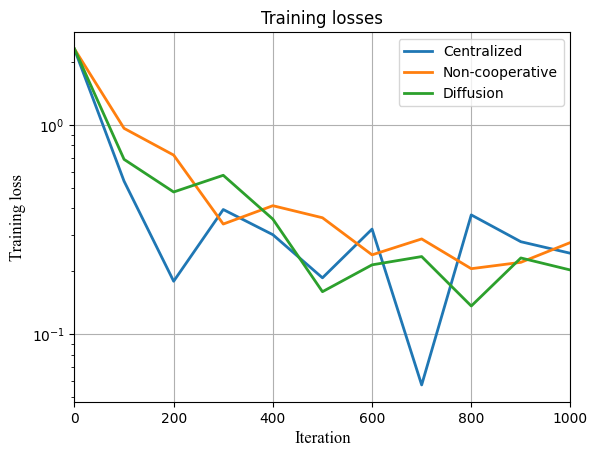

In [84]:
 
plt.figure()
plt.semilogy(log_x_axis, centralized_train_losses, linewidth=2, label='Centralized')
plt.semilogy(log_x_axis, noncoop_train_losses, linewidth=2, label='Non-cooperative')
plt.semilogy(log_x_axis, diffusion_train_losses, linewidth=2, label='Diffusion')
plt.title("Training losses")
plt.xlabel('Iteration',fontsize=12,fontname='times new roman')
plt.ylabel('Training loss',fontsize= 12,fontname='times new roman' )
plt.xlim(log_x_axis[0], log_x_axis[-1])
plt.legend()
plt.grid()
plt.savefig('train_loss.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


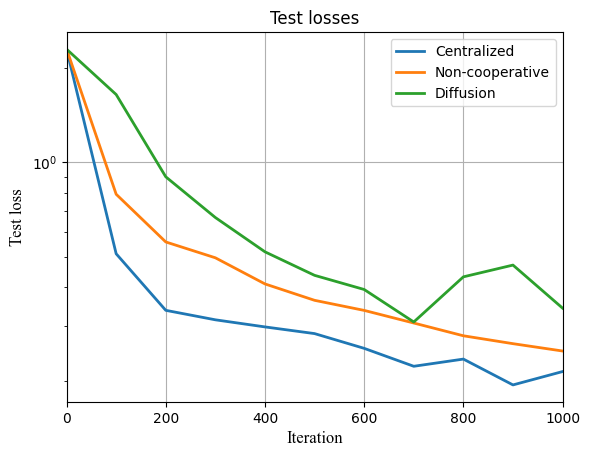

In [85]:
plt.figure()
plt.semilogy(log_x_axis, centralized_test_losses, linewidth=2, label='Centralized')
plt.semilogy(log_x_axis, noncoop_test_losses, linewidth=2, label='Non-cooperative')
plt.semilogy(log_x_axis, diffusion_test_losses, linewidth=2, label='Diffusion')
plt.title("Test losses")
plt.xlabel('Iteration',fontsize=12,fontname='times new roman')
plt.ylabel('Test loss',fontsize= 12,fontname='times new roman' )
plt.xlim(log_x_axis[0], log_x_axis[-1])
plt.legend()
plt.grid()
plt.savefig('test_loss.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


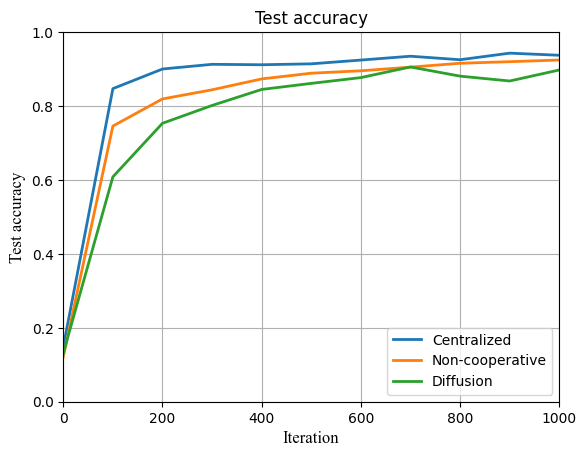

In [86]:
plt.figure()
plt.plot(log_x_axis, centralized_test_accuracy, linewidth=2, label='Centralized')
plt.plot(log_x_axis, noncoop_test_accuracy, linewidth=2, label='Non-cooperative')
plt.plot(log_x_axis, diffusion_test_accuracy, linewidth=2, label='Diffusion')
plt.title("Test accuracy")
plt.xlabel('Iteration',fontsize=12,fontname='times new roman')
plt.ylabel('Test accuracy',fontsize= 12,fontname='times new roman' )
plt.xlim(log_x_axis[0], log_x_axis[-1])
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.savefig('test_accuracy.eps', format='eps')
plt.show()